In [1]:
import pandas as pd
import numpy as np
from numpy import asarray
import scipy.io
from datetime import datetime, timedelta

import tensorflow as tf
from numpy import asarray


import keras
from PIL import Image
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, load_model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics


from keras.models import model_from_json
import matplotlib.pyplot as plt

import zipfile
import os
import gc

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
/Users/kalz/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
gc.collect()

37

**Extract the zipped file**

In [3]:
# with zipfile.ZipFile("ethnicity_clean.zip", "r") as zip_ref:
#     zip_ref.extractall()

In [4]:
target_size = (224, 224)

images_data = []
labels = []
#label classes
file_dir = ["asian", "black", "caucasian", "hispanic_latino", "mixed_race_person", "multi_ethnic_group", "native_american", "pacific_islander"]
for i in file_dir:
    path = f"./ethnicity_clean/{i}/"
    root = os.listdir(path)
    
    for ix in root:
        if not ix.endswith('DS_Store'):
            img = image.load_img(path+ix, grayscale=False, target_size=target_size)
            img_array = asarray(img).reshape(1, -1)[0]
            images_data.append(img_array)
            labels.append(i)
    print(f"completed {i} folder")


completed asian folder
completed black folder
completed caucasian folder
completed hispanic_latino folder
completed mixed_race_person folder
completed multi_ethnic_group folder
completed native_american folder
completed pacific_islander folder


In [5]:
images_data

[array([ 41,  61,  60, ..., 124,  52,  30], dtype=uint8),
 array([ 72, 102, 112, ...,   2,  19,  29], dtype=uint8),
 array([222, 222, 222, ..., 104, 125, 172], dtype=uint8),
 array([241, 242, 247, ..., 219, 219, 221], dtype=uint8),
 array([221, 228, 234, ..., 215, 178, 151], dtype=uint8),
 array([227, 226, 232, ..., 216, 215, 223], dtype=uint8),
 array([53, 68, 63, ..., 89, 96, 80], dtype=uint8),
 array([213, 223, 235, ..., 214, 227, 236], dtype=uint8),
 array([222, 223, 228, ..., 203, 204, 209], dtype=uint8),
 array([255, 238, 220, ...,  59, 114,  91], dtype=uint8),
 array([251, 251, 251, ...,  78,  66,  52], dtype=uint8),
 array([195, 203, 206, ..., 171, 174, 179], dtype=uint8),
 array([ 72,  99, 106, ...,  66,  95, 101], dtype=uint8),
 array([249, 249, 249, ..., 206, 192, 192], dtype=uint8),
 array([242, 242, 244, ..., 231, 230, 236], dtype=uint8),
 array([192, 175, 159, ..., 130,  96,  69], dtype=uint8),
 array([69, 72, 61, ...,  2, 17, 14], dtype=uint8),
 array([251, 251, 251, ...

In [6]:
labels_array = np.array(labels)

In [7]:
labels_array

array(['asian', 'asian', 'asian', ..., 'pacific_islander',
       'pacific_islander', 'pacific_islander'], dtype='<U18')

In [8]:
len(images_data)

12520

In [10]:
gc.collect()

20

In [11]:
df = pd.DataFrame({"pixels": images_data, "race": labels_array})
df.head()

,pixels,race
0,"[41, 61, 60, 40, 60, 59, 38, 58, 57, 37, 57, 5...",asian
1,"[72, 102, 112, 73, 103, 113, 75, 105, 115, 77,...",asian
2,"[222, 222, 222, 222, 222, 222, 222, 222, 222, ...",asian
3,"[241, 242, 247, 241, 242, 247, 241, 242, 247, ...",asian
4,"[221, 228, 234, 221, 228, 234, 221, 228, 234, ...",asian


In [12]:
df["ethnicity"] = df["race"].map({"asian": 0, "black": 1, "caucasian": 2, "hispanic_latino": 3, "mixed_race_person": 4, "multi_ethnic_group": 5,
                  "native_american": 6, "pacific_islander": 7})
df.head()

,pixels,race,ethnicity
0,"[41, 61, 60, 40, 60, 59, 38, 58, 57, 37, 57, 5...",asian,0
1,"[72, 102, 112, 73, 103, 113, 75, 105, 115, 77,...",asian,0
2,"[222, 222, 222, 222, 222, 222, 222, 222, 222, ...",asian,0
3,"[241, 242, 247, 241, 242, 247, 241, 242, 247, ...",asian,0
4,"[221, 228, 234, 221, 228, 234, 221, 228, 234, ...",asian,0


In [13]:
df["ethnicity"].value_counts()

0    3737
1    2910
3    2014
4    1914
2    1653
7     174
6      90
5      28
Name: ethnicity, dtype: int64

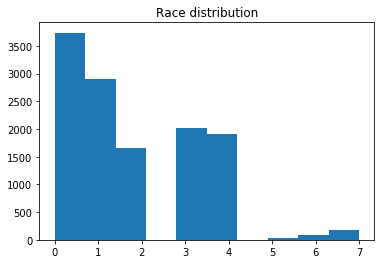

In [14]:
plt.hist(df["ethnicity"], )
plt.title("Race distribution");

In [15]:
#using keras, onehot encode the race column with respective classes
classes = 8  
target = df['ethnicity'].values
target_classes = keras.utils.to_categorical(target, classes)

In [16]:
#reshape the features
features = []
for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [17]:
features.shape

(12520, 224, 224, 3)

In [36]:
gc.collect()

20

In [21]:
features = features / 255

In [22]:
#convert features datatype to float
features = features.astype('float32')

## Train test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target_classes, test_size=0.2, random_state=42)

In [24]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [25]:
#load the weights
model.load_weights('/Users/kalz/Desktop/imdb-wiki/vgg_face_weights.h5')

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)    

In [37]:
model.layers[-4].output

<tf.Tensor 'dropout_2/cond/Identity:0' shape=(None, 1, 1, 4096) dtype=float32>

In [28]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

ethnicity_model = Model(inputs=model.input, outputs=base_model_output)

In [29]:
ethnicity_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  , metrics=['accuracy']
                 )

In [30]:
checkpointer = ModelCheckpoint(
    filepath='ethnicity_model'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [31]:
val_scores = []
train_scores = []
patience = 5

In [38]:
enableBatch = True
epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=patience) 

if enableBatch != True:
    
    score = ethnicity_model.fit(
        X_train, y_train, epochs = epochs, validation_data=(X_test, y_test), callbacks=[checkpointer, early_stop]
    )
else:
    batch_size = pow(2,8)
    last_improvement = 0
    best_iteration = 0
    
    loss = 100000 #initialize as a large value
    
    for i in range(0, epochs):
        
        print("Epoch ", i, ". ", end='')
        
        ix_train = np.random.choice(X_train.shape[0], size=batch_size)
        
        score = ethnicity_model.fit(
            X_train[ix_train], y_train[ix_train]
            , epochs=1
            , validation_data=(X_test, y_test)
            , callbacks=[checkpointer, early_stop]
        )
        
        val_loss = score.history['val_loss'][0]
        train_loss = score.history['loss'][0]
        
        val_scores.append(val_loss)
        train_scores.append(train_loss)
        
        #--------------------------------
        
        if val_loss < loss:
            loss = val_loss * 1
            last_improvement = 0
            best_iteration = i * 1
        else:
            last_improvement = last_improvement + 1
            print("try to decrease val loss for ",patience - last_improvement," epochs more")
        
        #--------------------------------
        
        if last_improvement == patience:
            print("there is no loss decrease in validation for ",patience," epochs. early stopped")
            break

Epoch  0 . Train on 256 samples, validate on 2504 samples
Epoch 1/1
256/256 [==============================] - 672s 3s/step - loss: 0.9795 - accuracy: 0.6445 - val_loss: 1.2090 - val_accuracy: 0.5643

Epoch 00001: val_loss improved from 1.21542 to 1.20896, saving model to ethnicity_model
Epoch  1 . Train on 256 samples, validate on 2504 samples
Epoch 1/1
256/256 [==============================] - 634s 2s/step - loss: 1.0191 - accuracy: 0.6289 - val_loss: 1.2386 - val_accuracy: 0.5531

Epoch 00001: val_loss did not improve from 1.20896
try to decrease val loss for  4  epochs more
Epoch  2 . Train on 256 samples, validate on 2504 samples
Epoch 1/1
256/256 [==============================] - 619s 2s/step - loss: 1.0192 - accuracy: 0.6797 - val_loss: 1.2487 - val_accuracy: 0.5423

Epoch 00001: val_loss did not improve from 1.20896
try to decrease val loss for  3  epochs more
Epoch  3 . Train on 256 samples, validate on 2504 samples
Epoch 1/1
256/256 [==============================] - 600s 2

In [ ]:
#check out train loss and test loss over epochs
train_loss = []
test_loss = []
for i in range(0,len(scores)):
    train_loss.append(scores[i].history['loss'])
    test_loss.append(scores[i].history['val_loss'])

#set figure size
plt.figure(figsize = (12,8))

#Generate line plot of training, testing loss over epochs
plt.plot(train_loss, label = 'Training loss', color = '#185fad')
plt.plot(test_loss, label = 'Testing loss', color = 'orange')

#set title
plt.title("Training and Testing loss by Epoch", fontsize = 25)
plt.xlabel("Epoch", fontsize = 18)
plt.ylabel("Categorical crossentropy", fontsize = 25)

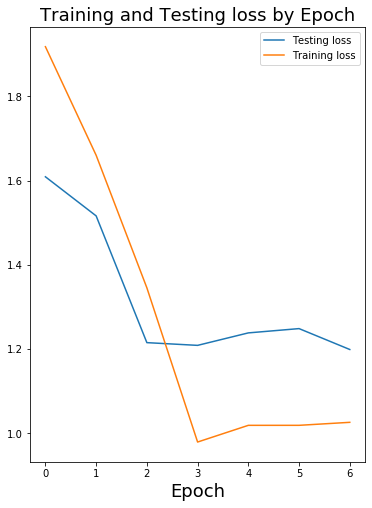

In [52]:
#set figure size
plt.figure(figsize = (6,8))
plt.title("Training and Testing loss by Epoch", fontsize = 18)
plt.xlabel("Epoch", fontsize = 18)

plt.plot(val_scores[0:best_iteration], label='Testing loss')
plt.plot(train_scores[0:best_iteration], label='Training loss')
plt.legend()
plt.show()

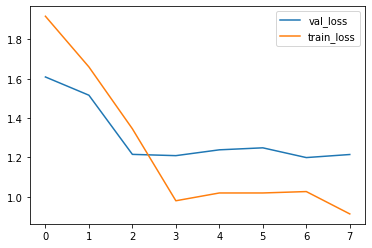

In [40]:
if enableBatch != True:
    plt.plot(score.history['val_loss'][0:best_iteration], label='val_loss')
    plt.plot(score.history['loss'][0:best_iteration], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()
else:
    plt.plot(val_scores[0:best_iteration+1], label='val_loss')
    plt.plot(train_scores[0:best_iteration+1], label='train_loss')
    plt.legend(loc='upper right')
    plt.show()

In [41]:
#restore the best weights
# ethnicity_model = load_model("ethnicity_model")

ethnicity_model.save_weights('ethnicity_weights')

In [43]:
gc.collect()

20

## Evaluate the Model

In [44]:
validation_performance = ethnicity_model.evaluate(X_test, y_test, verbose = 1)
validation_performance

2504/2504 [==============================] - 583s 233ms/step


[1.2587386362087993, 0.5499201416969299]

## Testing 

In [66]:
preds = ethnicity_model.predict(X_test)

In [112]:
preds.shape

(2504, 8)

In [110]:
class_labels =  np.array([i for i in range(0, 8)])

In [113]:
#Actual predictions
y_predictions = np.sum(preds * class_labels, axis = 1)

In [114]:
#create a function to load image with the VGG-face model input dimensions.
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [122]:
def ethnicity():
    groups = {0: "asian", 1:"black", 2:"caucasian", 3:"hispanic_latino", 4:"mixed_race_person", 
                5:"multi_ethnic_group", 6:"native_american", 7:"pacific_islander"}
    for i, v in groups.items():
        if k == i:
            return v

In [123]:
groups = {0: "asian", 1:"black", 2:"caucasian", 3:"hispanic_latino", 4:"mixed_race_person", 
                5:"multi_ethnic_group", 6:"native_american", 7:"pacific_islander"}

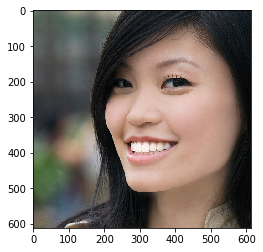

Predicted :  0
Actual Ethnicity:  1


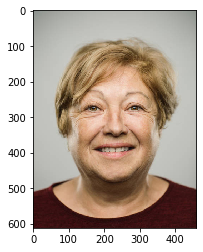

Predicted :  2
Actual Ethnicity:  3


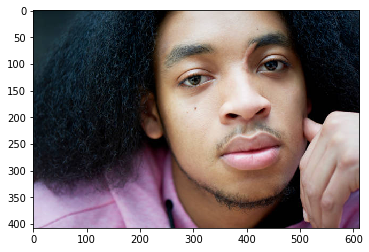

Predicted :  1
Actual Ethnicity:  1


In [128]:
pics = ["asian.jpg", "hispanic.jpg", "mixed_race.jpg"]

for i in pics:
    prediction = ethnicity_model.predict(loadImage(i))
    img = image.load_img(i)#, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    
    print("Predicted : ",np.argmax(prediction))

    apparent_age = np.round(np.sum(prediction * class_labels, axis = 1))
    print("Actual Ethnicity: ", int(apparent_age[0]))